<a href="https://www.kaggle.com/yanpapadakis/evaluation-of-nlp-models-eli5-shap?scriptVersionId=89422281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Evaluation of Machine Learning Models applied to Text Sentiment Analysis

The problem of making Machine Learning (ML) models as transparent as possible is receiving significant attention in the Data Sciece world. 
Model transparency is an important objective and attempts to achieve one or more of the following specific goals:

### 1. Understand model behavior and drivers enough in order to debug or, even better, improve an existing model along dimensions of interest

Questions we usually ask in order to get to this goal are:

- What are the key model drivers? How do they affect the model?

- What are key interactions between individual model drivers?

### 2. Figure out what is the range of application of an existing model (focus on implementation / performance monitoring)

- What data does the model work well on and what data receives inconclusive predictions/results?

- Often models lose their predictive power as time passes and the nature of the data changes. When the data mix collected for scoring is very different from the one at model development time predictions deteriorate. Can we predict how long a model can remain valid for?

- What cases become outliers depending on modeling strategy?

### 3. Understand why some cases fit well in the model while others are not (related to goal 2 but with focus on equity / impact disparity)

In a classification or regression setting some observations receive extreme estimated values and other average. In a clustering exercise, some observations belong clearly to clusters and others do not. Is it because this is the behavior of the underlying data? Or, is it that modeling choices favor/disfavor some classes of data?

### 4. Explore areas for model improvement.

Within a given methodology, how can we pick model parameters that a) optimize model performance (based on a preselected performance metric), and/or b) improve convergence speed.

We base our analysis on a model that is relatively easy to evaluate addressing a Natural Language Processing (NLP) problem. The problem is described in detail in the Quora Insincere Questions Competition and relevant data are easy to obain from Kaggle. The ML method we use here is a tree ensemble method, Gradient Boosting. We use open-source software for this exercise, Python SciKit-Learn. This well-maintained computing environment permits us to combine packages smoothly. The model fit we obtain is not as good as what we get from strategies based on Deep Learning (DL), in particular multi-layer neural networks for sequence processing with embeddings, bidirectional architecture, and attention layers.

We apply a number of common tools for model evalution:

- Feature Importance Analysis
- Analysis of the first (most important) tree in the ensemble
- In-depth analysis of selected documents, with emphasis on what our model misclassifies

In addition, we leverage 2 recently developed Python packages developed precisely to assist modelers in ML model interpretation. Both, packages provide tools specific to NLP models, which come in very handy for our task. They are:

- Eli5, and
- Shap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline, make_pipeline



import eli5
from eli5.lime import TextExplainer

import shap

Here are the data from Quora Insincere Questions Competition

For more details follow the link: https://www.kaggle.com/c/quora-insincere-questions-classification/overview

In [2]:
df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv",index_col=0)
print( df.info() )
print('\nTarget Level Counts:')
print(df.target.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 1306122 entries, 00002165364db923c7e6 to ffffed09fedb5088744a
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   question_text  1306122 non-null  object
 1   target         1306122 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ MB
None

Target Level Counts:
0    1225312
1      80810
Name: target, dtype: int64


To get a feel of the questions at hand and of the target variable (insincere question), here are some question examples by label.

In [3]:
n_examples_by_target = 100
test_examples = df.groupby("target").head(n_examples_by_target).sort_values(by='target')

with pd.option_context('display.max_colwidth', 400):
    for t in [0,1]:
        print("\n{} Question Examples\n".format(['Sincere','Insincere'][t]))
        for q in test_examples.loc[test_examples.target==t,'question_text'].iloc[:10]:
            print(q)


Sincere Question Examples

How did Quebec nationalists see their province as a nation in the 1960s?
Do web developer refer to W3C standard practice?
How do I work in cybersecurity overseas?
What are the characteristics that define isovolumetric relaxation?
Why doesn't eBay allow the sale of WWII purple heart medals even though they have categories specifically for WWII military medals?
How do I send large picture files through an email?
What is China's new chick?
How can I get cheap flights in Edinburgh?
What are the biggest problems, questions, doubts that you come across when trying to choose the paint color for a room?
What are the theories in critical thinking?

Insincere Question Examples

Why does everyone assume the NFL kneelers have a right to free speech? That right is not protected by employees from employers by 1st amendment.
Are there really enough fragments of the True Cross to fill a whole lumberyard? Or is that another myth propagated by atheists and Catholic-bashers?
W

# Develop Text Processing Pipeline

In [4]:
max_features = 5000 # Max Number of Words / NGrams to Consider
n_docs = 300000 # Number of Documents for Development and Validation
class_names = ['sincere','insincere']

In [5]:
# Vectorizer Definition and Parameters
# Parameter choices have significant impact and need to be optimized

vectorizer = TfidfVectorizer(min_df=10, max_df=0.1, max_features=max_features)

In [6]:
# GB Classifier Definition and Parameters
# Again parameter choices are very important. They impact model performance and computational cost/time.

clf = GradientBoostingClassifier(n_estimators=100, max_depth=6, subsample=0.7, random_state=21)

The data is too big for the available computational resources, so we select a subset for development and validation.

In [7]:
np.random.seed(2021)
idx = np.random.choice(len(df),n_docs)
n_cut = int(n_docs*0.66)
train_idx = idx[:n_cut]
test_idx = idx[n_cut:]
print(len(train_idx),len(test_idx))

198000 102000


In [8]:
train_set = (df.iloc[train_idx,0].values, df.iloc[train_idx,1].values)
test_set  = (df.iloc[test_idx,0].values,  df.iloc[test_idx,1].values)

We need to be able to score documents in raw form. To make this easy we fit a pipeline that vectorizes and classifies.

In [9]:
pipe = make_pipeline(vectorizer, clf)

pipe.fit(*train_set)
pipe.score(*test_set)

0.9463921568627451

Fit is good, but not as good as what we get with DL models. See also F1_Score below.

#### Vectorizer Parameters

Some were selected before, others get default values.

In [10]:
pipe[0].get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.1,
 'max_features': 5000,
 'min_df': 10,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [11]:
features = vectorizer.get_feature_names()

**Words With High TFIDF Sum**

In [12]:
X = vectorizer.transform(test_set[0])
print(*sorted([w for w,x in zip(features,np.ravel(X.sum(0))) if x > 200]))

2017 about after all am an any anyone as at back bad be become been before being best better between book books business but buy by change china college company could country day did difference different does don during engineering english even ever examples experience feel find first free from get getting girl give go good had happen has have having he help her high his if important india indian into its job just know language learn life like live long look love made make many me mean men money more most much my name need new no not now number old on one online only or other our out over own people person possible quora real really right same say school science see sex should so some someone start still stop student study system take than that their them there they thing things think this time trump two university up us use used using want was water way ways we were when where which while white who will with without women work world would year years your


Note prevalence of India, Indians, 2017, Trump, Quora. These words capture the period (2017, Trump), an overrepresented demographic group (Indians), and words specific to this application (Quora). Naturally, we expect that as time goes by some of these words will lose their value as predictors and other might gain additional importance (e.g., Quora, Quorans).

#### Classifier Fit Evaluation

**OOB Improvement Analysis**

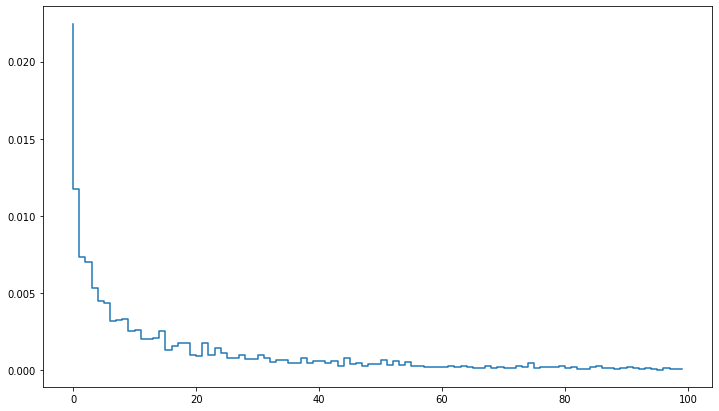

In [13]:
pd.Series(clf.oob_improvement_).plot(figsize=(12,7),drawstyle="steps");

The model converged in 100 steps, reaching low error values after 30 rounds. Observe, the jump in the first step. The first tree in the ensemble captures about 40% of the explanatory power of the full ensemble.

Our focus here is on ML model evaluation, so this model is not optimized. A different modeling strategy, restricting tree depth to a low value (i.e. permitting only shallow trees in the ensemble) might have resulted in a better fit, but the first tree would not capture as much from the essence of the ensemble.

In [14]:
y_pred = pipe.predict_proba(df.iloc[test_idx,0].values)[:,1] > 0.06
print(classification_report(df.iloc[test_idx,1].values, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     95572
           1       0.29      0.77      0.42      6428

    accuracy                           0.87    102000
   macro avg       0.64      0.82      0.67    102000
weighted avg       0.94      0.87      0.89    102000



The performance is relatively good, but DL models, as mentioned earlier, have better performance and in particular better F1-score. The objective in this competition is to optimize the F1-score and the winners used DL models.

## Feature Importance

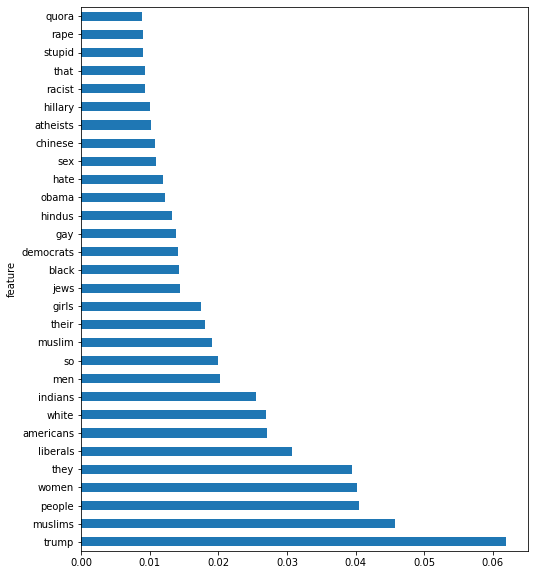

In [15]:
(
    pd.DataFrame({
        'feature': features,
        'importance': clf.feature_importances_,
    })
    .sort_values('importance', ascending=False)
).iloc[:30].set_index('feature')['importance'].plot.barh(figsize=(8,10));

We observe that "loaded" words, e.g. "Trump," "muslims," "gay," tend to top the list of most prevalent terms in the tree ensemble. We will remark in a following section below that other words, e.g. mathematical or scientific terminology, tend to be associated with sincere questions. The latter, though, are not at the top of the feature importance list.

## Overview of First Tree

It carries the most predictive power, close to half the one obtained by the full ensemble.

Some prior exposure to Decision Trees permits us to understand how many terms combine to produce insincere questions. For instance, the combination of women-white-get leads to one of the highlighted in deep orange leafs below. A combination of muslims with south leads to a negative logit and therefore lower likelihood for a question with insincere label. This is the power of analyzing the first tree in an ensemble, if tree complexity is not too high (in this case max tree depth is 6). In contrast, all other methods below are not well suited to evaluate interactions of model drivers.

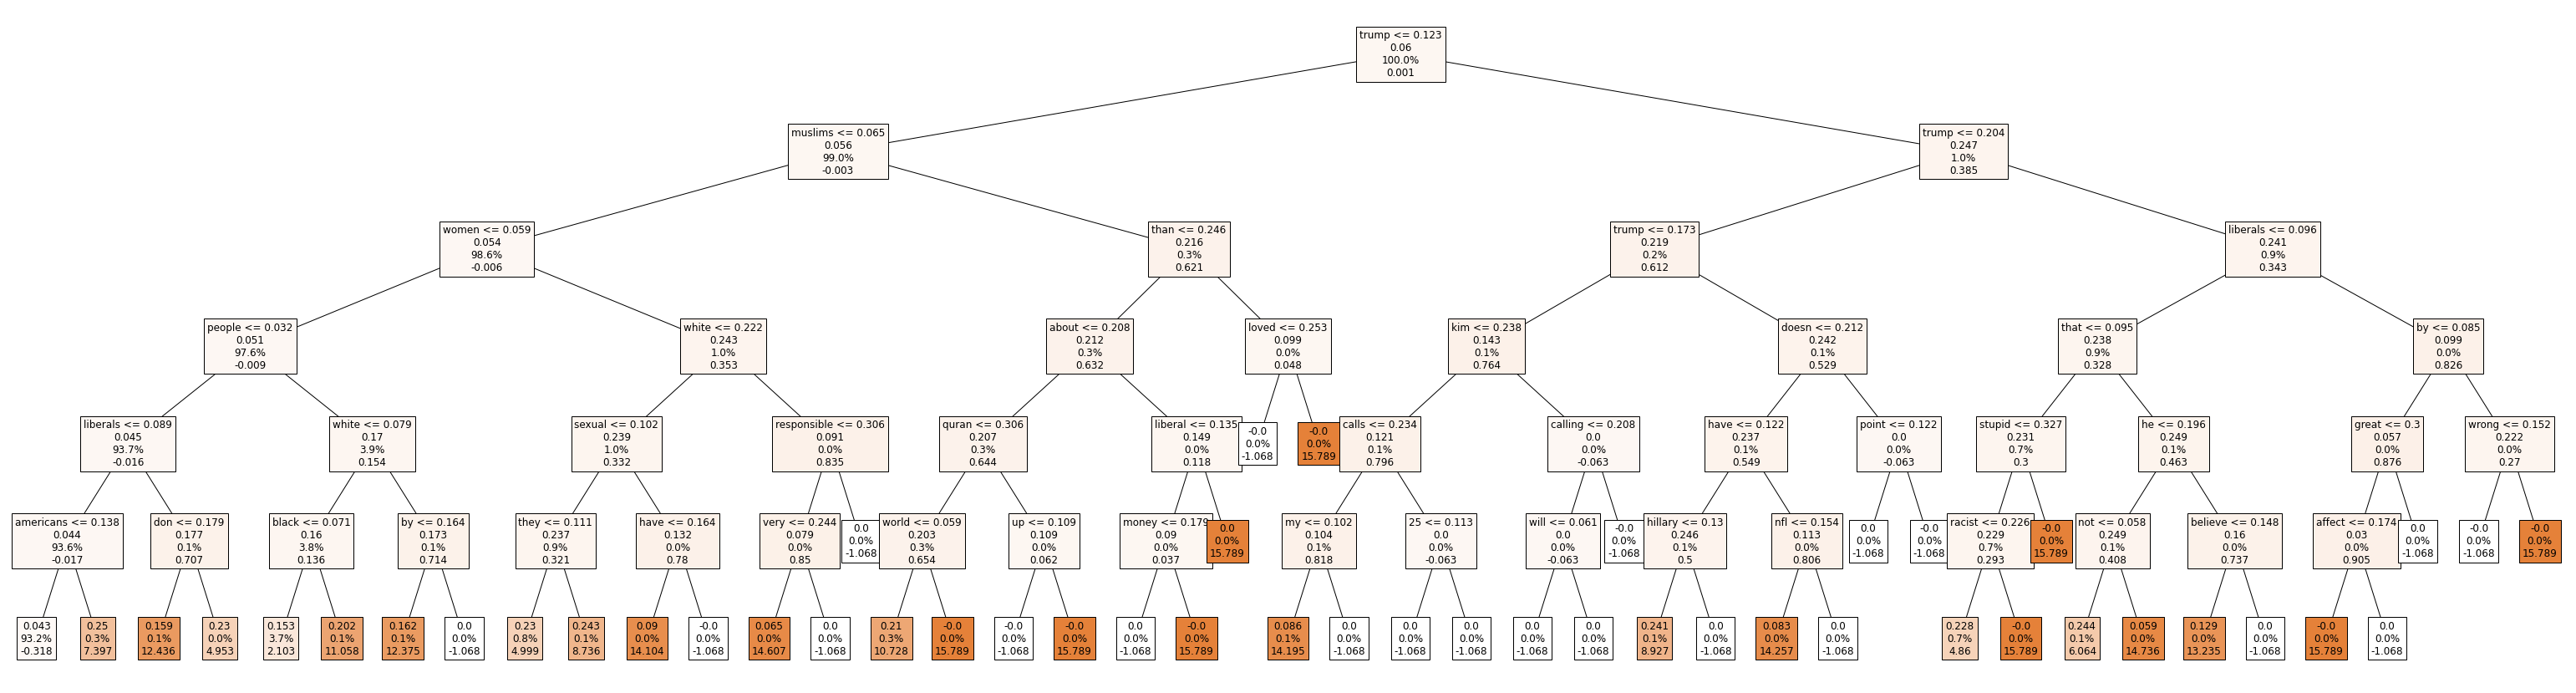

In [16]:
plt.figure(figsize=(55,15))
tree.plot_tree(clf.estimators_[0][0],fontsize=12,filled=True, feature_names=features, label=None, proportion=True);

In [17]:
print(tree.export_text(clf.estimators_[0][0], feature_names=features))

|--- trump <= 0.12
|   |--- muslims <= 0.07
|   |   |--- women <= 0.06
|   |   |   |--- people <= 0.03
|   |   |   |   |--- liberals <= 0.09
|   |   |   |   |   |--- americans <= 0.14
|   |   |   |   |   |   |--- value: [-0.32]
|   |   |   |   |   |--- americans >  0.14
|   |   |   |   |   |   |--- value: [7.40]
|   |   |   |   |--- liberals >  0.09
|   |   |   |   |   |--- don <= 0.18
|   |   |   |   |   |   |--- value: [12.44]
|   |   |   |   |   |--- don >  0.18
|   |   |   |   |   |   |--- value: [4.95]
|   |   |   |--- people >  0.03
|   |   |   |   |--- white <= 0.08
|   |   |   |   |   |--- black <= 0.07
|   |   |   |   |   |   |--- value: [2.10]
|   |   |   |   |   |--- black >  0.07
|   |   |   |   |   |   |--- value: [11.06]
|   |   |   |   |--- white >  0.08
|   |   |   |   |   |--- by <= 0.16
|   |   |   |   |   |   |--- value: [12.38]
|   |   |   |   |   |--- by >  0.16
|   |   |   |   |   |   |--- value: [-1.07]
|   |   |--- women >  0.06
|   |   |   |--- white <= 0.22
| 

# Model Evaluation and Transparency

We focus on the examples we selected randomly earlier and pick cases that were misclassified by our model as well as some that were correctly classified. We try to develop insights about our model by examining these examples in detail. For consistentcy, the same examples will be analyzed below using the model transparency utilities Eli5 and Shap.

In [18]:
ex_score = pipe.predict_proba(test_examples.question_text.values)[:,1]
pd.Series(ex_score).describe()

count    200.000000
mean       0.154895
std        0.205329
min        0.027031
25%        0.029393
50%        0.044819
75%        0.220891
max        0.994153
dtype: float64

In [19]:
ex_sincere   = sorted(["{:.3f}|{:3d}".format(s,i) for i, s in enumerate(ex_score[:n_examples_by_target])], reverse=True)
ex_insincere = sorted( "{:.3f}|{:3d}".format(s,i) for i, s in enumerate(ex_score[n_examples_by_target:],start=100))
print('Sincere Examples')
print(" With relatively high probability of being insincere")
print(*ex_sincere[:5],sep="\n")
print(" Correctly estimated")
print(*ex_sincere[-5:],sep="\n")
print('\n\nInsincere Examples')
print(" Incorrectly estimated")
print(*ex_insincere[:5],sep="\n")
print(" Correctly estimated")
print(*ex_insincere[-5:],sep="\n")

Sincere Examples
 With relatively high probability of being insincere
0.360| 65
0.258| 51
0.239| 69
0.223| 68
0.211| 62
 Correctly estimated
0.029|  5
0.029|  2
0.029|  1
0.027| 45
0.027| 41


Insincere Examples
 Incorrectly estimated
0.029|103
0.029|104
0.029|109
0.029|117
0.029|118
 Correctly estimated
0.731|178
0.772|198
0.970|141
0.993|160
0.994|140


In [20]:
exid = [65, 51, 41, 103, 104, 140]

In [21]:
# Preprocess and Tokenize Just as in Development Time
vpre = vectorizer.build_preprocessor()
vtok = vectorizer.build_tokenizer()

**FI Color Scale**

Words not in model are not highlighted

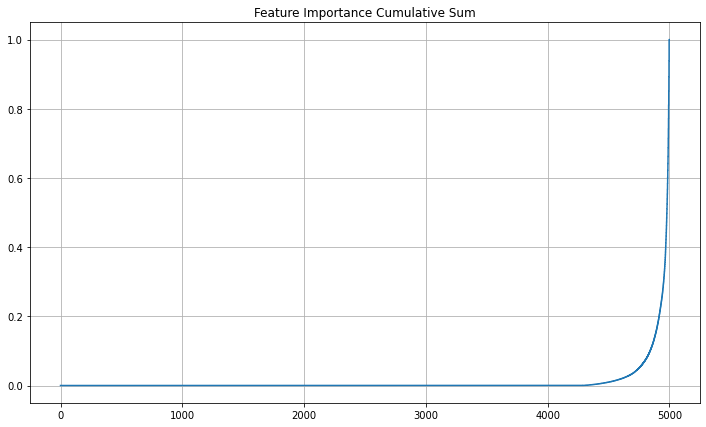

In [22]:
pd.Series(np.cumsum(sorted(clf.feature_importances_))).plot(figsize=(12,7),drawstyle="steps",grid=True,title="Feature Importance Cumulative Sum");

In [23]:
word_fi = clf.feature_importances_[clf.feature_importances_>1e-3]
print("Top {:3d} Words Capture {:5.1%} of Feature Importance".format(len(word_fi), word_fi.sum()))
word_fi2 = word_fi[word_fi>0.5e-2]
print("Top {:3d} Words Capture {:5.1%} of Feature Importance".format(len(word_fi2), word_fi2.sum()))

Top 140 Words Capture 88.5% of Feature Importance
Top  38 Words Capture 66.6% of Feature Importance


Note that only 140 out of 5,000 words capture 88.5% of total feature importance. 38 words capture 2/3 of feature importance.

In [24]:
fi_bins = [0,1e-3,5e-3,1e-2,1]
fid = np.digitize(clf.feature_importances_, fi_bins) - 1
fi_intensity = {w:k for k,w in zip(fid,features)}

In [25]:
def fi_word_color(w,i):
    # grey, yellow, magenta, red
    cmap = [97, 93, 95, 91]
    return f'\033[{cmap[i]};4m' + w + '\033[0m'

for i, x in enumerate(zip(fi_bins,fi_bins[1:])):
    print( fi_word_color("FI from {:.4f} to {:.4f}".format(*x),i) )

FI from 0.0000 to 0.0010
FI from 0.0010 to 0.0050
FI from 0.0050 to 0.0100
FI from 0.0100 to 1.0000


In [26]:
def doc_highlight(doc,fn,intensity):
    tokens = vtok(vpre(doc))
    out = []
    for w in tokens:
        out.append( fn(w, intensity[w]) if w in intensity else w)
    return ' '.join(out)

#### Highlight Documents Using Feature Importance

In [27]:
for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(doc_highlight(test_examples.question_text.values[id],fi_word_color,fi_intensity))
    print()

True Class: sincere Score=0.3597
is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved completely disregarding their feelings lives so you get to have something go your way and feel temporarily at ease how did things change

True Class: sincere Score=0.2576
how many indians are in melbourne australia

True Class: sincere Score=0.0270
what are some best college for aircraft propulsion

True Class: insincere Score=0.0294
what is the most degrading way to insult grammar obsessed overweight misfit homeschooled bimbo

True Class: insincere Score=0.0294
would it be possible to create better and bigger version of auschwitz with giant incinerators rather than gas chambers

True Class: insincere Score=0.9942
when will americans recognize that southern conservatives those who whine about obama jim crow appreciators are the biggest problem with america and that nothing will get solved until they are put in their place



Red words tend to be the biggest drivers as far as our fitted model is concerned. 

- In the second question, "indians" animates our model giving this question higher probability than it deserves.

- In the fourth question, the word "most" is surprisingly the most meaningful by our model. The string of insults "overweight misfit homeschooled bimbo" is not even underlined, as these terms do not even belong to the model vocabulary of top 5,000 words. Looking at this, a modeling strategy that naturally suggests itself is to increase our model's vocabulary by enhancing the development sample and our investment in computational resources.

**Probability Insincere Color Scale**

Words not in model are not highlighted

In [28]:
p_num = pipe.predict_proba([''])[0][1] # Use as numeraire the probability insincere associated with any UNKNOWN word if taken in isolation
pi_bins = [0,p_num,2*p_num,3*p_num,4*p_num,1]
pid = np.digitize(pipe.predict_proba(features)[:,1], pi_bins) - 1
pi_intensity = {w:k for k,w in zip(pid,features)}

In [29]:
def pi_word_color(w,i):
    # grey, yellow, magenta, red
    cmap = [42,46,47,43,41]
    return f'\x1b[5;39;{cmap[i]}m' + w + '\x1b[0m'

for i, x in enumerate(zip(pi_bins,pi_bins[1:])):
    print( pi_word_color("FI from {:.4f} to {:.4f}".format(*x),i) )

FI from 0.0000 to 0.0294
FI from 0.0294 to 0.0588
FI from 0.0588 to 0.0882
FI from 0.0882 to 0.1176
FI from 0.1176 to 1.0000


#### Highlight Documents Using Invidual Word Probability

In [30]:
for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(doc_highlight(test_examples.question_text.values[id],pi_word_color,pi_intensity))
    print()

True Class: sincere Score=0.3597
is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved completely disregarding their feelings lives so you get to have something go your way and feel temporarily at ease how did things change

True Class: sincere Score=0.2576
how many indians are in melbourne australia

True Class: sincere Score=0.0270
what are some best college for aircraft propulsion

True Class: insincere Score=0.0294
what is the most degrading way to insult grammar obsessed overweight misfit homeschooled bimbo

True Class: insincere Score=0.0294
would it be possible to create better and bigger version of auschwitz with giant incinerators rather than gas chambers

True Class: insincere Score=0.9942
when will americans recognize that southern conservatives those who whine about obama jim crow appreciators are the biggest problem with america and that nothing will get solved until they are put in their place



In some questions we see emerging patterns using this analysis:

- Question 2: Teal words combined with a red word ("indians") result in higher probability insincere for the question as a whole

- Question 3: Teal words combined with a green word, carrying positive meaning by our model ("best"), result in low probability insincere for the question as a whole

- Questions 4 & 5: many teal words without accompanying red/yellow words result in undeservedly low probability insincere for the question as a whole.

Both pictures (feature importance highlighting and probability highlighting) provide some helpful insights, but fail to provide insights about how drivers interact to increase or reduce the likelihood of a question being labeled insincere.

## 1. ELI5 

### TextExplainer

In [31]:
for id in exid:
    doc = test_examples.question_text.values[id]
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    te = TextExplainer(random_state=42)
    te.fit(doc, pipe.predict_proba)
    display(te.show_prediction(target_names=class_names))

True Class: sincere Score=0.3597


True Class: sincere Score=0.2576


True Class: sincere Score=0.0270


True Class: insincere Score=0.0294


True Class: insincere Score=0.0294


True Class: insincere Score=0.9942


**These examples provide some interesting insights:**

- First Question, "Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. how did things change?", is labeled "sincere" but prob insincere is 36%. It seems that the given label is arbitrary, so this analysis does help to debug the model and the data collection process.

- Third Question, "what are some best college for aircraft propulsion(m.s)?", here the words "college," "aircraft," and "propulsion" appear to help the model classify the question correctly as sincere. Unfortunately, the word "propulsion" is not in the vocabulary of vectorized terms (it is coded as unknown word).

- Fourth Question, "what is the most degrading way to insult a grammar obsessed overweight misfit homeschooled bimbo?". Looking at the text explainer one observes that the words 'way," "grammar," and "overweight," have a stronger effect than "obsessed bimbo" and result in the question being misclassified as "sincere". Many of these words (e.g., "degrading," "bimbo"), though, have no relation to our model and they do not belong to the vocabulary of vectorized words.

**Overall**

This tool creates its own default model and does not explain the model we developed.

#### Eli5 Feature Importance

In [32]:
x_res = vectorizer.transform(test_examples.question_text.values)
y_res = test_examples.target.values

In [33]:
eli5.show_weights(clf, feature_names = features, top=50)

Weight,Feature
0.0620 ± 0.1048,trump
0.0458 ± 0.0839,muslims
0.0405 ± 0.0803,people
0.0401 ± 0.0838,women
0.0395 ± 0.0828,they
0.0307 ± 0.0770,liberals
0.0271 ± 0.0742,americans
0.0269 ± 0.0688,white
0.0254 ± 0.0825,indians
0.0202 ± 0.0717,men


This tool is useful but seems to provide the same results with feature importance at a significantly higher computational cost. 

To be fair Eli5 tries to provide insights even when model methodology is unknown.

An additional metric "permuation importance" has very high computational cost and we didn't evaluate it here.

# SHAP Analysis

In [34]:
x_res = vectorizer.transform(test_examples.question_text.values)
x_res_df = pd.DataFrame(x_res.todense(), columns = features)

In [35]:
explainer = shap.Explainer(clf)

shap_values = explainer(x_res_df)

In [36]:
shap.initjs()

for id in exid:
    print("True Class:",class_names[test_examples.target[id]],"Score={:.4f}".format(ex_score[id]))
    print(test_examples.iloc[id,0])
    display(shap.plots.force(shap_values[id], feature_names=features))

True Class: sincere Score=0.3597
Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?


True Class: sincere Score=0.2576
How many Indians are in Melbourne, Australia?


True Class: sincere Score=0.0270
What are some best college for aircraft propulsion(M.S)?


True Class: insincere Score=0.0294
What is the most degrading way to insult a grammar obsessed overweight misfit homeschooled bimbo?


True Class: insincere Score=0.0294
Would it be possible to create a better and bigger version of Auschwitz with giant incinerators rather than gas chambers?


True Class: insincere Score=0.9942
When will Americans recognize that southern conservatives (those who whine about Obama, Jim Crow appreciators) are the biggest problem with America and that nothing will get solved until they are put in their place?


Interesting graph, but the weights of each word in a sentence (Shapley values) appear arbitrary. Again, they seem to capture the sum of individual effects and not the effect of word interactions.

#### Shap's Alternatives of Feature Importance

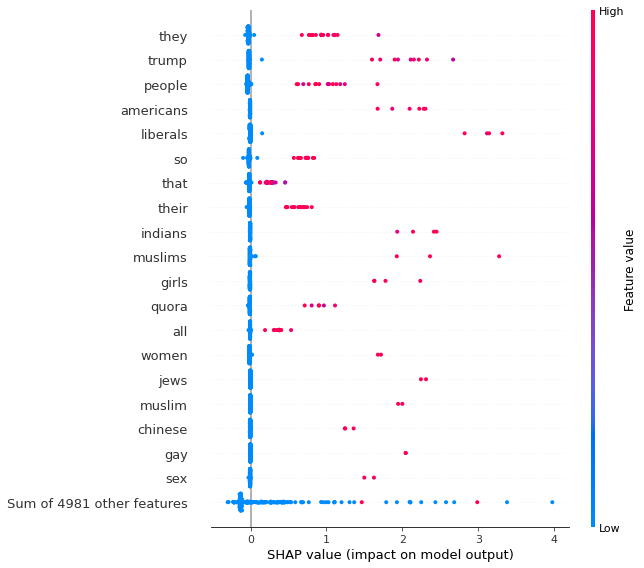

In [37]:
shap.initjs()
shap.plots.beeswarm(shap_values,20)

This graph appears to capture the terms at the top of the feature importance list. Hence, it is useful. But, complex calculations need to take place to obtain this graph.

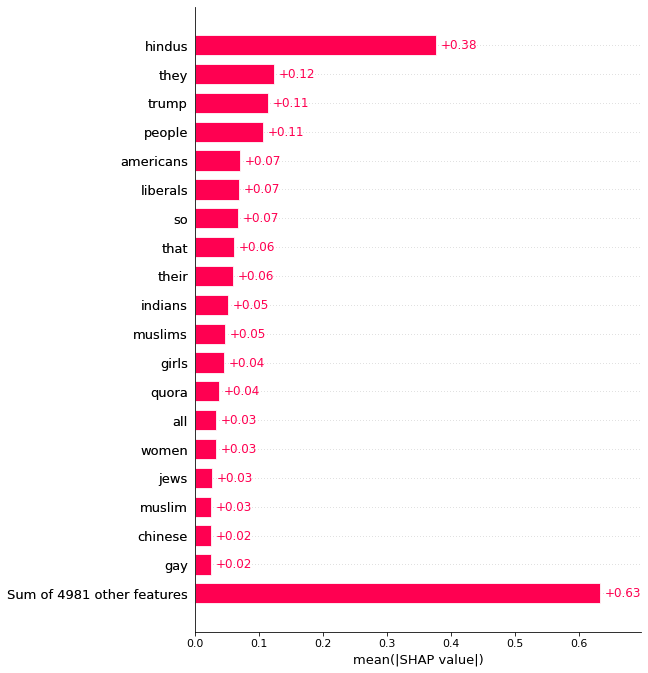

In [38]:
shap.plots.bar(shap_values, 20)

This graph is an alternative view of the beeswarm plot.

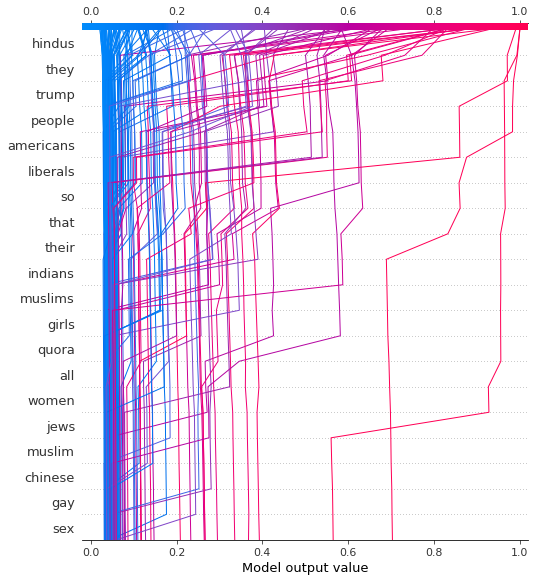

In [39]:
shap.decision_plot(explainer.expected_value, shap_values.values, features, link='logit')

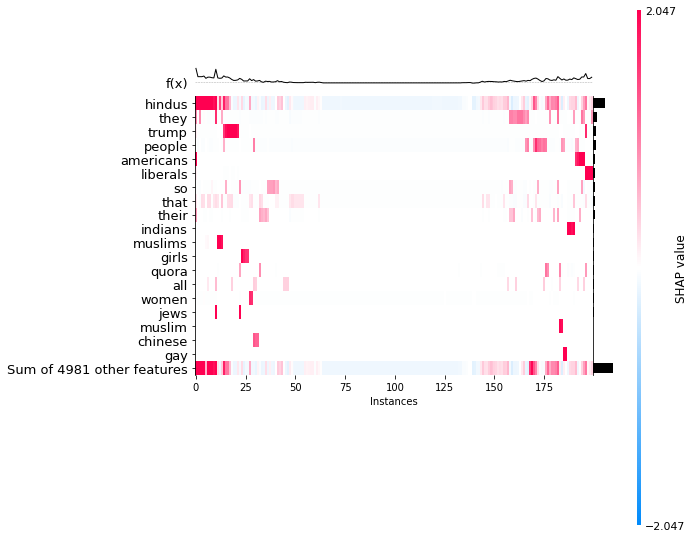

In [40]:
shap.plots.heatmap(shap_values, max_display = 20)

Again, the heatmap plot appears to show the words from the feature importance short-list, but assigns difficult to interpet weights to them. More important, we get no insights about how words interact to change a document's classification.

# Conclusion

We return to the model evaluation objectives in the beginning of this review and provide a summary of how well we did with our analysis. The results are not promissing either when one uses the standard methods (feature importance and top tree in ensemble) or when newer approaches, like Eli5 and Shap, are used.

- Understand model behavior and drivers enough in order to debug or, even better, improve an existing model

Our analysis does provide insights that help us understand the nature of the data at hand and the consistency of labels. Unfortunately, only top-tree analysis provides some insights about model driver interaction and this is only available and meaningful when using tree ensemble methods with a top tree that is interpretable and has high explanatory value. So, we need a top tree with not too many branches **and** explanatory value comparable to the one on the ensemble.

At the end of this exercise, our insights are little useful in improving the model (see model optimization below).

- Figure out what is the range of application of an existing model

Some insights are useful. Certain words reflect discussions in the period the data were collected (2017, Trump, Muslims). We expect that the model will lose its explanatory power now, in 2021. Some neutral words (e.g. "southern", "college") in contrast might retain their value. 

We cannot see how one can provide answers about our dataset's range of application (a model expiration date if you will) that are significantly more detailed than what we reported in the previous sentence. Of course, when the model loses its predictive power, then we know its validity is in question, but we cannot predict in advance model deterioration, as we could have if we fully understood model structure. 

- Why do some cases achieve high importance (score) and others do not?

ML models are not transparent and we have encountered cases where positive and negative terms interact in ways that are difficult to understand. 

In general, it is possible to establish with this analysis some types of systematic biases. For instance, this dataset shows that a lot of people from India like to participate in Quora and it seems that their perspectives are relatively more prevalent. It is difficult, however, to get an even deeper appreciation of which subgroups of the Indian population were represented in Quora circa 2017. 

- How can we optimize a machine learning model?

The typical way to optimize a ML model is to perform some sort of hyper-parameter optimization. This process is not much dependent on the results of the previous analysis. 

Given insights from previous work on the same dataset, however, we have concluded that these Quora questions contain many spelling errors, have international characters, and may benefit from masking numbers (i.e., instead of using 134 and 182 as separate words combine them all as 3 digit numbers). All these insights might help model optimization, but require significant detective work and are not the outcome of a simple model evaluation process.

*Overall assessment*: We considered a tree-ensemble model which does not perform as well as, say, DL models, but is relatively easier to interpret. After some reasonable steps at model evaluation we find that we know very little about how our model works or about the nature of our dataset. The Socratic saying "the only true wisdom is in knowing you know nothing" fits particularly well to machine learning modeling.